In [2]:
import sys 
import numpy as np 
import pandas as pd 
import scipy 
import matplotlib as mpl 
mpl.rcParams['figure.dpi'] = 400 
import matplotlib.pyplot as plt 
%matplotlib inline 
import sklearn 
import xgboost as xgb 

import pickle
import shap 

In [3]:
from sklearn.datasets import make_classification 

X, y = make_classification(n_samples=5000, n_features=40,
                           n_informative=3, n_redundant=2,
                           n_repeated=0, n_classes=2,
                           n_clusters_per_class=3,
                           weights=None, flip_y = 0.05,
                           class_sep=0.1, hypercube=True,
                           shift=0.0, scale=1.0, shuffle=True,
                           random_state=2)

In [4]:
y.mean()

0.4986

In [5]:
# Instead of cross-validation, split data once into training and validation dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=24)

In [6]:
xgb_model_1 = xgb.XGBClassifier(n_estimators=1000, verbosity=1,
                                use_label_encoder=False,
                                objective='binary:logistic',  # cross-entropy /log-loss from logistic regression
                                learning_rate=0.3,
                                eval_metric='auc',
                                booster='gbtree')

`use_label_encoder` is deprecated in 1.7.0.


In [7]:
%%time 
xgb_model_1.fit(X_train, y_train, verbose=True)

CPU times: user 24.6 s, sys: 3.13 s, total: 27.8 s
Wall time: 4.46 s


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [8]:
#'manually' calculating roc_auc_score
from sklearn.metrics import roc_auc_score

val_set_pred_proba = xgb_model_1.predict_proba(X_val)[:,1]
roc_auc_score(y_val, val_set_pred_proba)

0.7787643196395633

In [9]:
# the training set and validation set (in that order) together form the evaluation set
eval_set = [(X_train, y_train), (X_val, y_val)]

In [10]:
%%time 
xgb_model_1.fit(X_train, y_train,       # data to be used for training
              eval_set=eval_set,        # evaluate eval_metric on each of (data, response); last is validation
              verbose=True,             # print training progress to screen
              early_stopping_rounds=30) # validation eval_metric not improving for 30 rounds, refit w/ last 30

[0]	validation_0-auc:0.80412	validation_1-auc:0.75223
[1]	validation_0-auc:0.84422	validation_1-auc:0.79207
[2]	validation_0-auc:0.85920	validation_1-auc:0.79278
[3]	validation_0-auc:0.86616	validation_1-auc:0.79517


[4]	validation_0-auc:0.88261	validation_1-auc:0.79659
[5]	validation_0-auc:0.88605	validation_1-auc:0.80061
[6]	validation_0-auc:0.89226	validation_1-auc:0.80224
[7]	validation_0-auc:0.89826	validation_1-auc:0.80305
[8]	validation_0-auc:0.90559	validation_1-auc:0.80095
[9]	validation_0-auc:0.91954	validation_1-auc:0.79685
[10]	validation_0-auc:0.92113	validation_1-auc:0.79608
[11]	validation_0-auc:0.92393	validation_1-auc:0.79763
[12]	validation_0-auc:0.92526	validation_1-auc:0.79842
[13]	validation_0-auc:0.92699	validation_1-auc:0.79883
[14]	validation_0-auc:0.93105	validation_1-auc:0.79716
[15]	validation_0-auc:0.94393	validation_1-auc:0.79750
[16]	validation_0-auc:0.95007	validation_1-auc:0.79431


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[17]	validation_0-auc:0.95204	validation_1-auc:0.79407
[18]	validation_0-auc:0.95610	validation_1-auc:0.79127
[19]	validation_0-auc:0.95920	validation_1-auc:0.79136
[20]	validation_0-auc:0.96175	validation_1-auc:0.79044
[21]	validation_0-auc:0.96329	validation_1-auc:0.78943
[22]	validation_0-auc:0.96978	validation_1-auc:0.78885
[23]	validation_0-auc:0.97344	validation_1-auc:0.78685
[24]	validation_0-auc:0.97510	validation_1-auc:0.78467
[25]	validation_0-auc:0.97846	validation_1-auc:0.78461
[26]	validation_0-auc:0.98116	validation_1-auc:0.78222
[27]	validation_0-auc:0.98354	validation_1-auc:0.78127
[28]	validation_0-auc:0.98562	validation_1-auc:0.78135
[29]	validation_0-auc:0.98638	validation_1-auc:0.78227
[30]	validation_0-auc:0.98717	validation_1-auc:0.78286
[31]	validation_0-auc:0.98958	validation_1-auc:0.78330
[32]	validation_0-auc:0.99104	validation_1-auc:0.78241
[33]	validation_0-auc:0.99169	validation_1-auc:0.78323
[34]	validation_0-auc:0.99278	validation_1-auc:0.78261
[35]	valid

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [11]:
# access boosting rounds for optimal validation score using .get_booster().attributes()
xgb_model_1.get_booster().attributes()

{'best_iteration': '7',
 'best_ntree_limit': '8',
 'best_score': '0.8030501882609966'}

In [12]:
# "manually" calculating roc_auc_score
val_set_pred_proba_2 = xgb_model_1.predict_proba(X_val)[:,1]
roc_auc_score(y_val, val_set_pred_proba_2)

0.8030501882609966

#### Tuning the Learning Rate

In [13]:
# learning rate values to tune
learning_rates = np.linspace(start=0.01, stop=1, num=25)

In [14]:
%%time 
val_aucs = []
best_iters = []
for learning_rate in learning_rates:
    xgb_model_1.set_params(**{'learning_rate': learning_rate})  # update hyperparameter by set_params()
    xgb_model_1.fit(X_train, y_train, 
                    eval_set=eval_set, # we need eval_set because of early_stopping_rounds 
                    verbose=False,    # we don't need to see eval_metric printed on screen   
                    early_stopping_rounds=30)   # if eval_metric on last set in eval_set dont improve for 30 rou
    val_set_pred_proba_2 = xgb_model_1.predict_proba(X_val)[:,1]  # predicted prob of positive class membership
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba_2))   #  
    best_iters.append(int(xgb_model_1.get_booster().attributes()['best_iteration']))

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`early_sto

CPU times: user 56 s, sys: 15.1 s, total: 1min 11s
Wall time: 11.1 s


In [15]:
learning_rate_df = pd.DataFrame({'Learning rate': learning_rates,
                                 'Validation AUC': val_aucs,
                                 'Best Iteration': best_iters})

In [16]:
learning_rate_df.head()

,Learning rate,Validation AUC,Best Iteration
0,0.01000,0.810249,222
1,0.05125,0.810795,43
2,0.09250,0.811531,21
3,0.13375,0.808364,16
4,0.17500,0.806187,13


<Axes: xlabel='Learning rate'>

<Figure size 2560x1920 with 0 Axes>

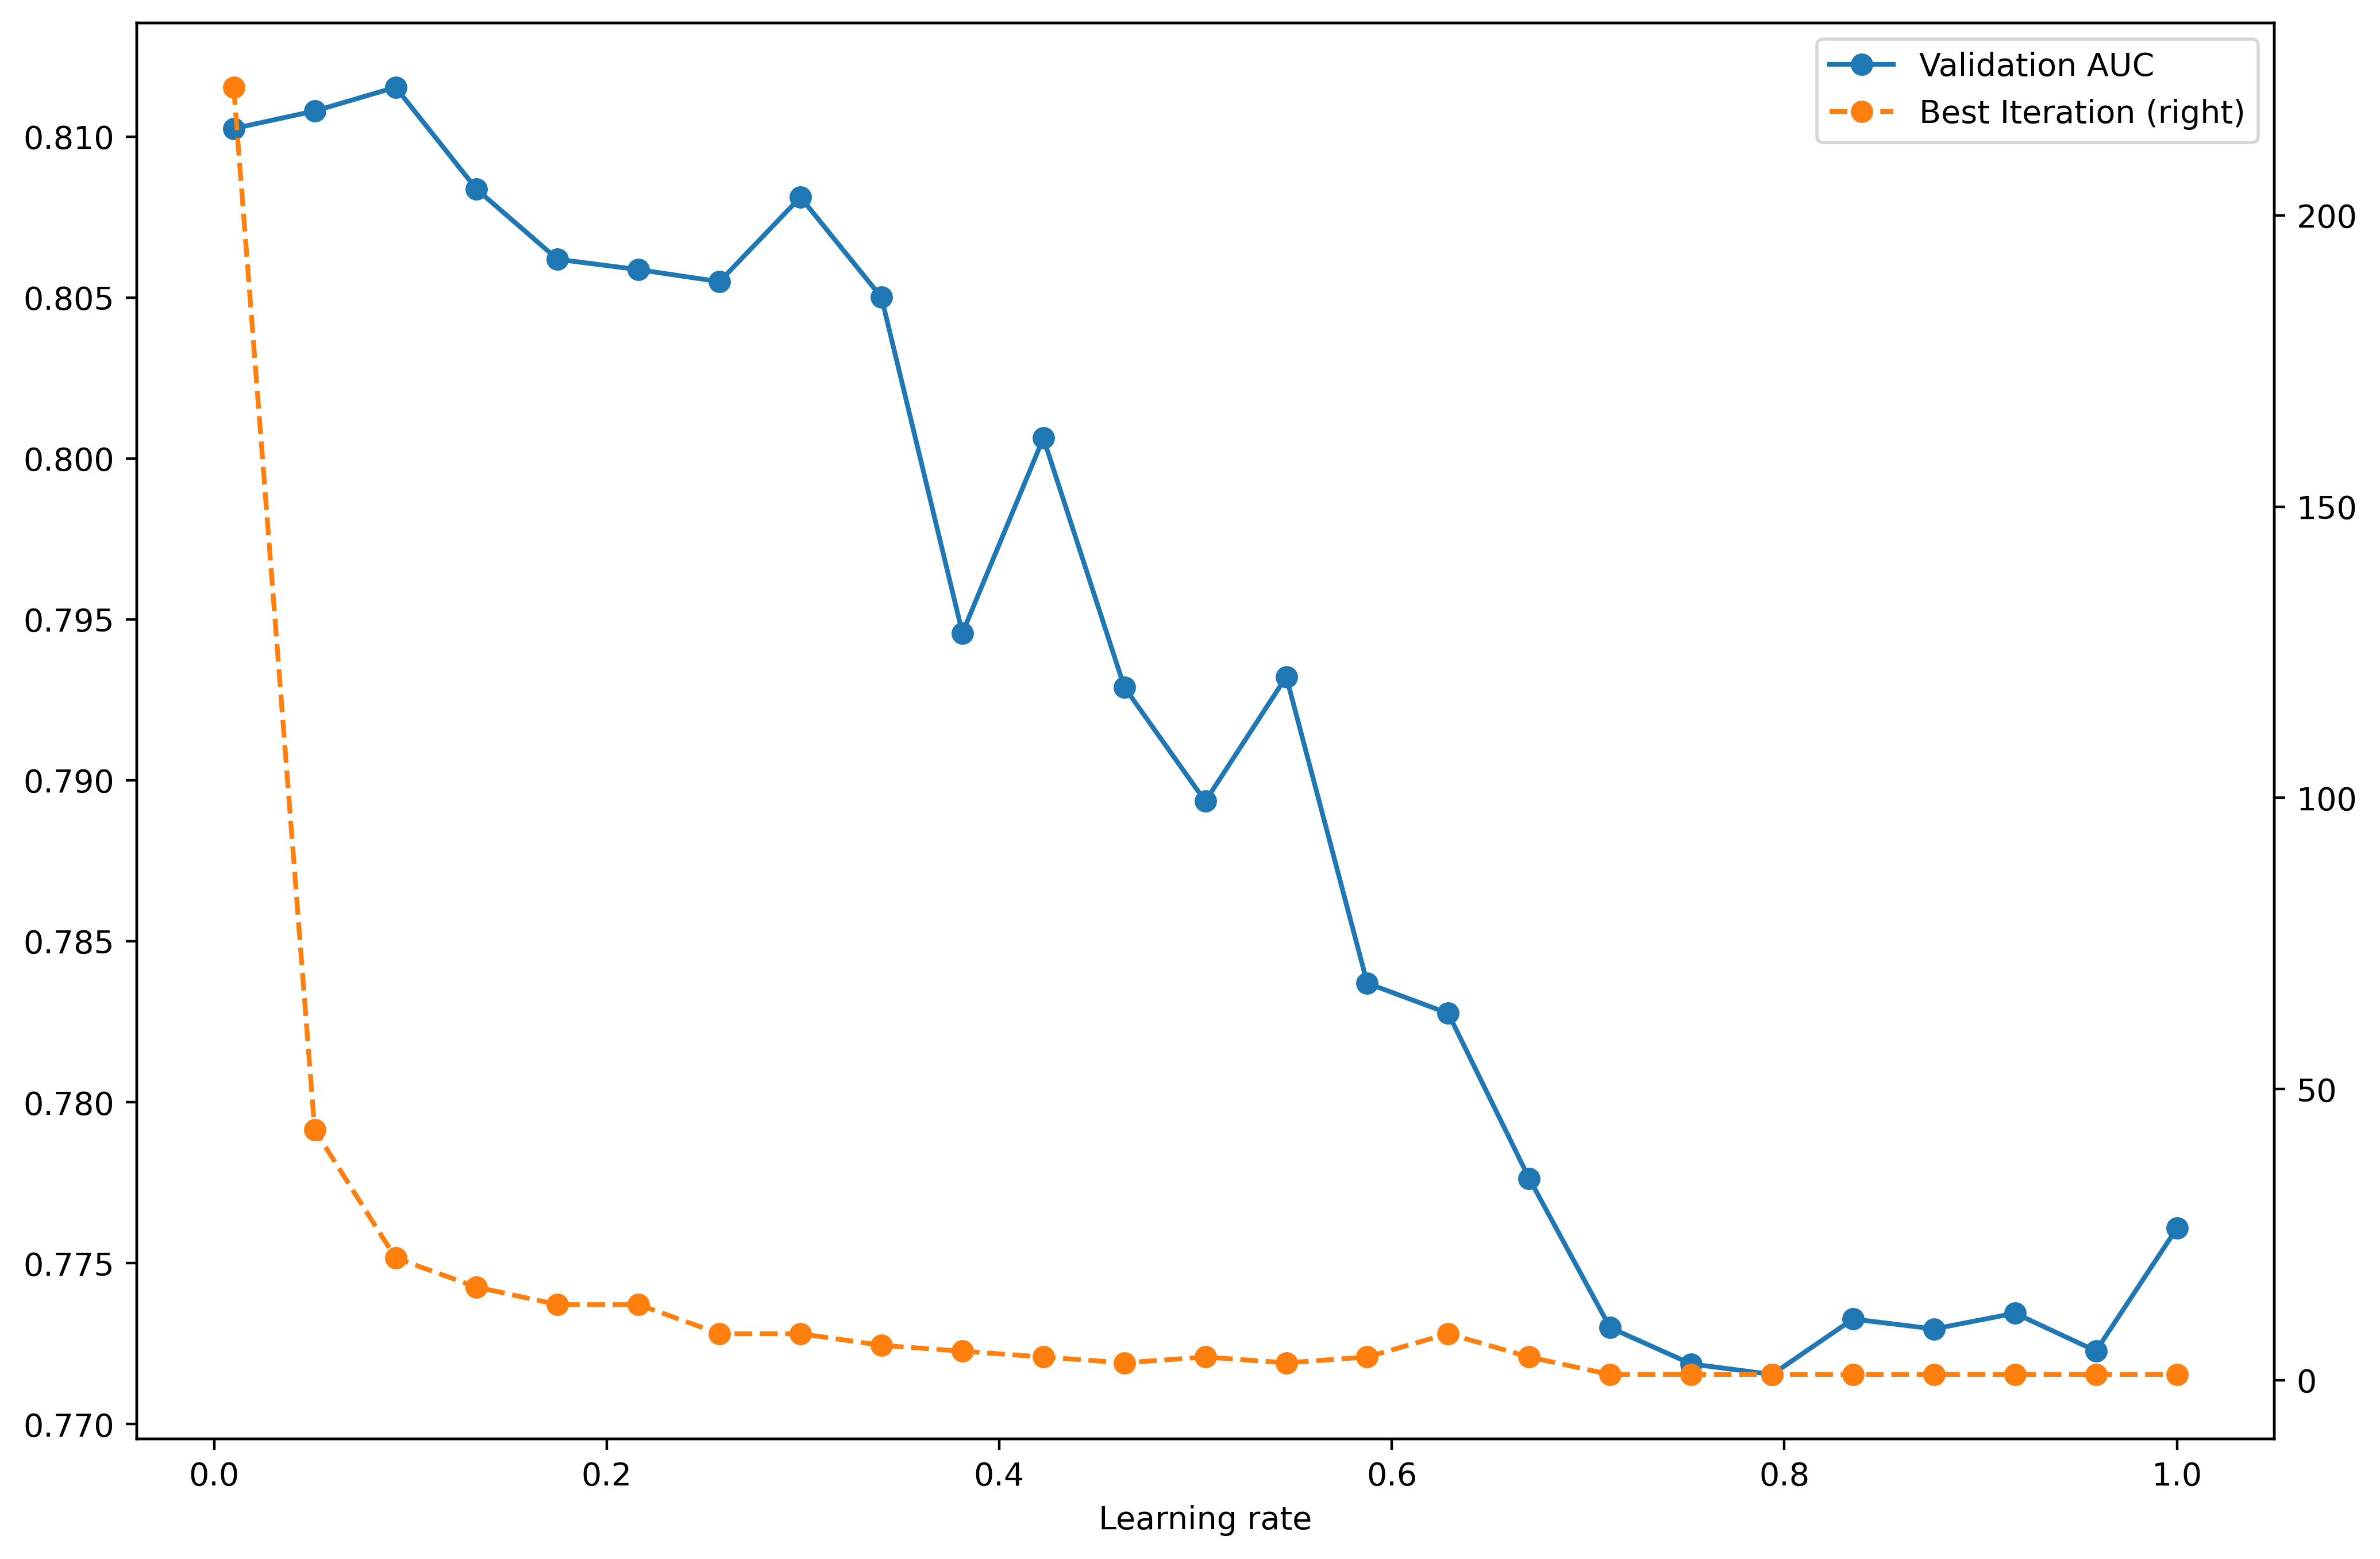

In [17]:
# Visualizing performance and the number of iterations
mpl.rcParams['figure.dpi'] = 400
plt.figure()
learning_rate_df.set_index('Learning rate').plot( # x-axis is index (default), so set learning rate as index
    secondary_y='Best Iteration', # plot all columns, make best iteration a second y-axis
    style=['-o', '--o'], 
    figsize=(12,8))   

In [18]:
max(val_aucs)

0.8115309360232714

In [19]:
learning_rates[np.argmax(val_aucs)]

0.0925

#### Randomized Grid Search for Tuning XGBoost Hyperparameters

For discrete hyperparameters, we use a list. For continuous hyperparameters, we use distribution objects. In the code below we use a uniform distribution for gamma, colsample_bytree, subsample, learning_rate hyperparameters. By default, scipy's uniform distribution is over [0,1]. To modify the bounds of the interval over which we sample for each hyperparameter, we provide loc, scale parameters to the uniform distribution,so we sample from interval [loc, loc+scale].  

To do the random sampling of hyperparameter combinations, we use scikit-learn's ParameterSampler class, which we provide the dictionary of param_grid and n_iter keyword for the number of samples to return. Below, we also set random_state for reproducible runs.

In [20]:
from scipy.stats import uniform 

param_grid = {'max_depth': [2,3,4,5,6,7],   # allowable depth of trees, list()
              'gamma': uniform(loc=0.0, scale=3), # min loss function reduction for nodesplit; [0,0+3]=[0,3]
              'min_child_weight': list(range(1,151)), # min samples in leaf nodes, list()
              'colsample_bytree': uniform(loc=0.1, scale=0.9), # fraction of features [0.1, 0.1+0.9] = [0.1, 1]
              'subsample': uniform(loc=0.5, scale=0.5), # fraction of samples used [0.5, 0.5+0.5] = [0.5, 1]
              'learning_rate': uniform(loc=0.01, scale=0.5)} # how much step taken each tree growing round

In [21]:
from sklearn.model_selection import ParameterSampler
rng = np.random.RandomState(0)
n_iter = 1000
param_list = list(ParameterSampler(param_grid, 
                                   n_iter=n_iter, 
                                   random_state=rng)) # parameter sample as a dictionary, pack to list of dicts

In [22]:
param_list[0]

{'colsample_bytree': 0.5939321535345923,
 'gamma': 2.1455680991172583,
 'learning_rate': 0.31138168803582195,
 'max_depth': 5,
 'min_child_weight': 104,
 'subsample': 0.7118273996694524}

In [23]:
# Initialize xgb parameter
xgb_model_2 = xgb.XGBClassifier(n_estimators=1000,
                                verbosity=1,
                                use_label_encoder=False,
                                objective='binary:logistic', # cross-entropy loss for binary classification
                                eval_metric='auc',
                                early_stopping_rounds=30)  
xgb_model_2.set_params(**param_list[0])

`use_label_encoder` is deprecated in 1.7.0.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5939321535345923, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2.1455680991172583, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.31138168803582195, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=104, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [25]:
%%time 
val_aucs = []
counter = 1 
for params in param_list:
    # Set hyperparameters of xgb model using .set_params() and dict unpacking **
    xgb_model_2.set_params(**params)
    # Fit the model
    xgb_model_2.fit(X_train, y_train, 
                    eval_set=eval_set,
                    verbose=False)
    # Get predicted probabilities and save validation ROC AUC 
    val_set_pred_proba = xgb_model_2.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba))
    # Print progress
    if counter % 50 == 0:
        print(f"Done with {counter} of {n_iter}")
    counter += 1

Done with 50 of 1000
Done with 100 of 1000
Done with 150 of 1000
Done with 200 of 1000
Done with 250 of 1000
Done with 300 of 1000
Done with 350 of 1000
Done with 400 of 1000
Done with 450 of 1000
Done with 500 of 1000
Done with 550 of 1000
Done with 600 of 1000
Done with 650 of 1000
Done with 700 of 1000
Done with 750 of 1000
Done with 800 of 1000
Done with 850 of 1000
Done with 900 of 1000
Done with 950 of 1000
Done with 1000 of 1000
CPU times: user 19min 27s, sys: 6min 10s, total: 25min 37s
Wall time: 4min 9s


In [ ]:
# put the selected parameter combinations in a dataframe
xgb_param_search_df = pd.DataFrame(param_list)
xgb_param_search_df.head()

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample
0,0.593932,2.145568,0.311382,5,104,0.711827
1,0.681305,1.312762,0.455887,2,141,0.691721
2,0.812553,1.586685,0.294022,7,26,0.535518
3,0.178416,0.060655,0.426310,2,83,0.736804
4,0.820820,1.561432,0.349440,2,10,0.768687


In [ ]:
# add the validation metric scores as a column to dataframe
xgb_param_search_df['Validation ROC AUC'] = val_aucs 
max_auc = xgb_param_search_df['Validation ROC AUC'].max()
max_auc

0.8151220995602575

#### Marginal distributions of AUCs with respect to each parameter

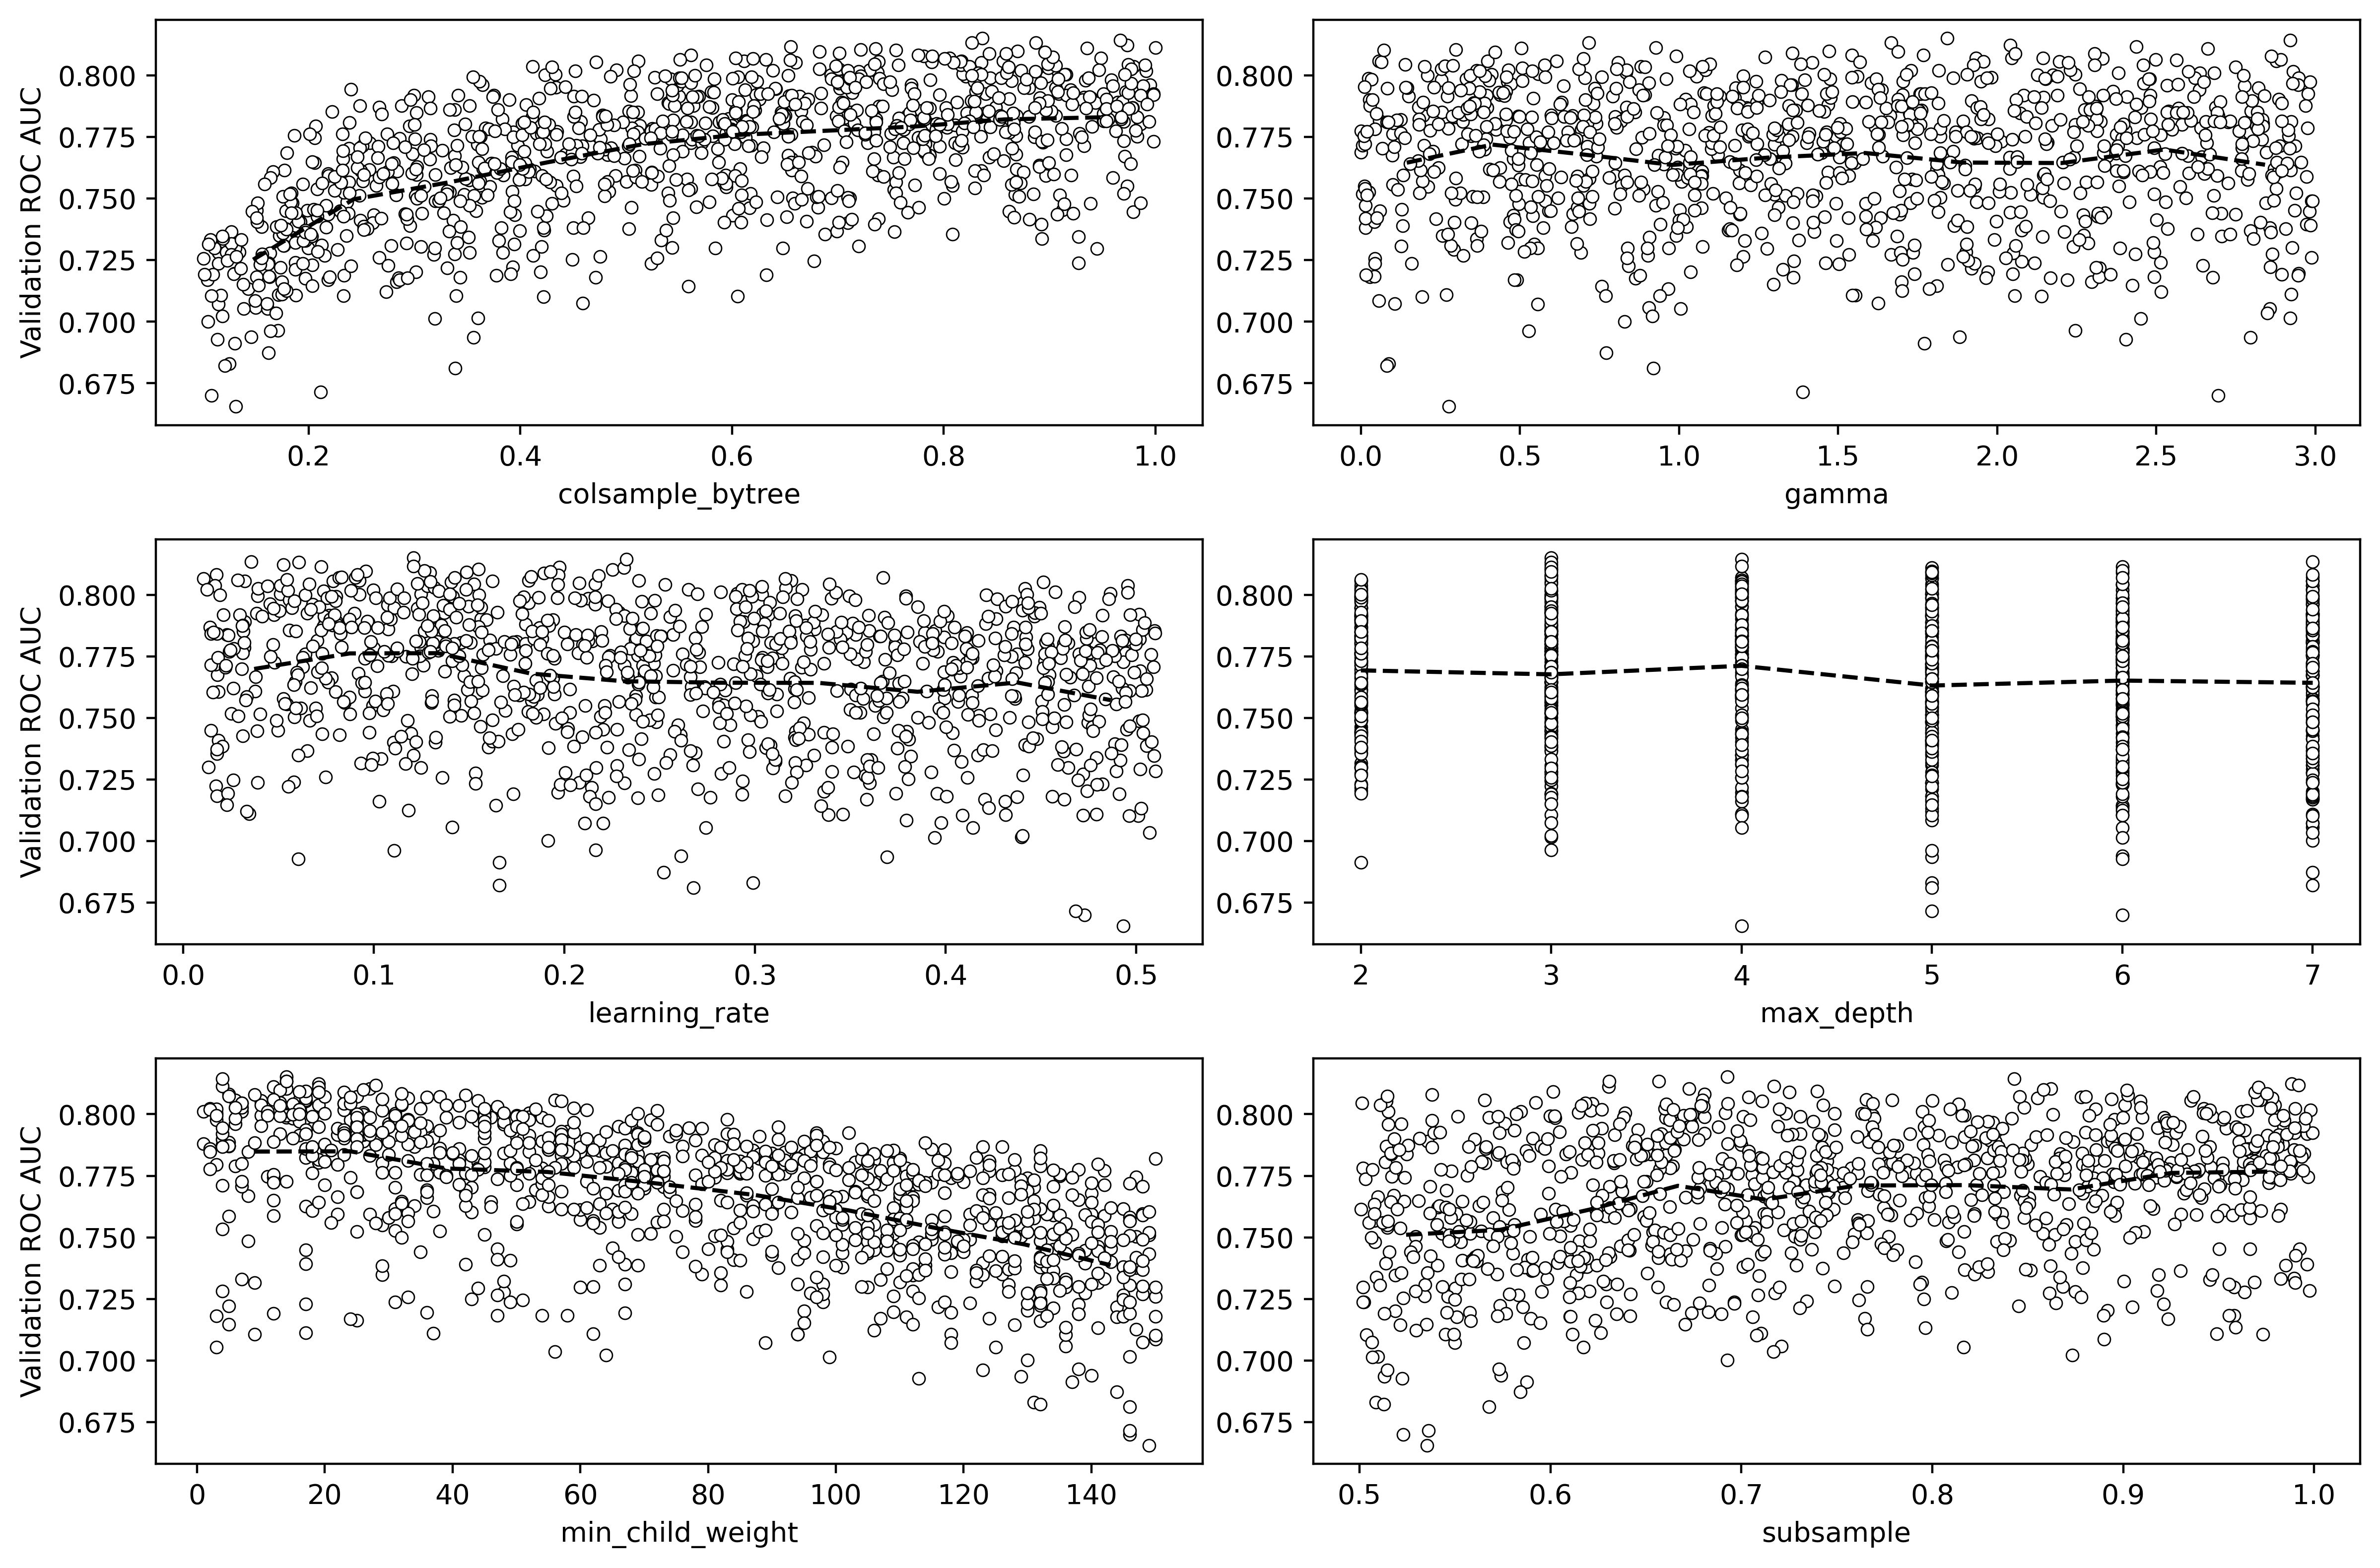

In [ ]:
mpl.rcParams['figure.dpi'] = 400 
fig, axs = plt.subplots(3,2, figsize=(12,8))
counter = 0
for col in xgb_param_search_df.columns[:-1]:
    this_ax = axs.flatten()[counter]            # flatten the ndarray of axes, so we can index like a list

    xgb_param_search_df.plot.scatter(x=col,     # scatter plot of column values and metric scores
                                     y='Validation ROC AUC',
                                     ax=this_ax,    # each column get its own axes
                                     marker='o',
                                     color='w',
                                     edgecolor='k',
                                     linewidth=0.5)
    
    # Since the y-axis is the same for all plots, we only need to include it in the first one
    if counter%2 != 0:
        this_ax.set_ylabel('')
    counter += 1

    # create deciles of the continously distributed hyperparameter
    if col != 'max_depth' : 
        out, bins = pd.qcut(xgb_param_search_df[col], q=10, # out is decile val belongs to, bins is the deciles
                            retbins=True, duplicates='drop') 
        half_points = [(bins[ix] + bins[ix+1])/2        # mid point of bins by sliding window; for plotting
                       for ix in range(len(bins) - 1)]  # for sliding window left idx goes to penultimate
    else: # for max_depth which is discrete
        out = xgb_param_search_df[col]      # the each value belongs to its own bin
        half_points = np.sort(xgb_param_search_df[col].unique()) # mid point is the unique values
    
    tmp_df = xgb_param_search_df.copy() # make copy of dataframe as our temporary dataframe
    tmp_df['param_decile'] = out        # add the decile of each value in current category
    # use temporary dataframe to find the average value oof metric within each decile of current hyperparameter
    mean_df = tmp_df.groupby('param_decile').agg({'Validation ROC AUC': 'mean'}) # average metric per decile

    # visualize the average metric score per decile and plot as a line graph
    this_ax.plot(half_points, mean_df.values, color='k', linestyle='--')
plt.tight_layout()

The plots above show how XGBoost hyperparameters affect model performance for this particular dataset. 

One way XGBoost combats overfitting is by limiting the data available when growing trees, either by randomly sampling a fraction of the features available to each tree (colsample_bytree), or a fraction of the training samples (subsample). Note that the documentation says to start subsample from 0.5, which makes sense because performance depends on information. Unsurprisingly, the model performs best when using 100% of the features and samples for each tree. 

Another way to control overfitting, is to limit the complexity of the trees by controlling their max_depth, the minimum number of training samples in leaves (min_child_weight), or the minimum reduction in the value of the loss function reduction requied to split a node (gamma). Neither max_depth or gamma appear to have much effect on model performance, while limiting the number of samples in the leaves actually degrades model performance.

For the current dataset, it appears the gradient boosting is robust enough to achieve good model performamce, without additional tricks required to reduce overfitting. With that said, a smaller learning _rate is beneficial.

Even with the randomized grid search for optimal hyperparameters, the maximum validation set AUC is similar to what was achieved by tuning only the learning rate.

In [ ]:
max_ix = xgb_param_search_df['Validation ROC AUC'] == max_auc  # a boolean array
max_ix

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: Validation ROC AUC, Length: 1000, dtype: bool

In [ ]:
xgb_param_search_df[max_ix]  # index with boolean array

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,subsample,Validation ROC AUC
308,0.83627,1.843039,0.120745,3,14,0.692646,0.815122


#### XGBoost's Grow Policy

The default grow policy in xgboost is depthwise which grows trees to an indicated max_depth. Another option is lossguide grow policy, which splits the node that results in the greatest reduction in the loss function (eg binary:logistic aka cross-entropy for binary), regardless of how deep it will make the tree. This may result in an unbalanced tree. To set the grow policy, its important to set the tree_method which is either hist or gpu_hist. 

The hist method is a faster way of searching for splits. Instead of looking between sorted feature values for training samples in a node, the hist method builds a histogram and only considers the edges of the histogram. So for 100 samples, their feature values may be binned into 10 groups, meaning there are only 9 possible splits to consider instead of 99. The lossguide grow policy mimics the behavior of LightGBM. 

Because max_depth doesnt matter when we are using lossguide grow_policy (with a chosen tree_method of hist), we set the max_depth to 0. However, we are able to tune another hyperparameter max_leaves, which controls the maximum number of leaf nodes in trees that will be grown. 

In [ ]:
xgb_model_3 = xgb.XGBClassifier(n_estimators=100,
                                max_depth=0, # max_depth isnt relevant for lossguide so set to 0
                                learning_rate=0.1, # take 10% of the step suggested by gradient/hessian
                                verbosity=1, 
                                objective='binary:logistic',
                                n_jobs=-1,
                                tree_method='hist',
                                grow_policy='lossguide',
                                eval_metric='auc',
                                early_stopping_rounds=30)

In [ ]:
# we are going to set max_leaves instead of max_depth for lossguide policy
max_leaves_values = list(range(5,105,5))
print(max_leaves_values[:5])
print(max_leaves_values[-5:])

[5, 10, 15, 20, 25]
[80, 85, 90, 95, 100]


In [ ]:
%%time 
val_aucs =  []
for max_leaves in max_leaves_values:
    # Set hyperparameter and fit model 
    xgb_model_3.set_params(**{'max_leaves': max_leaves}) 
    xgb_model_3.fit(X_train, y_train,
                    eval_set=eval_set,
                    verbose=False)
    # Get validation score 
    val_set_pred_proba = xgb_model_3.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba))

CPU times: user 44 s, sys: 15.2 s, total: 59.2 s
Wall time: 9.61 s


In [ ]:
max_leaves_df = pd.DataFrame({'Max leaves': max_leaves_values,
                              'Validation AUC': val_aucs})

In [ ]:
max_leaves_df.head()

,Max leaves,Validation AUC
0,5,0.807316
1,10,0.808366
2,15,0.814310
3,20,0.815120
4,25,0.810859


<Axes: xlabel='Max leaves'>

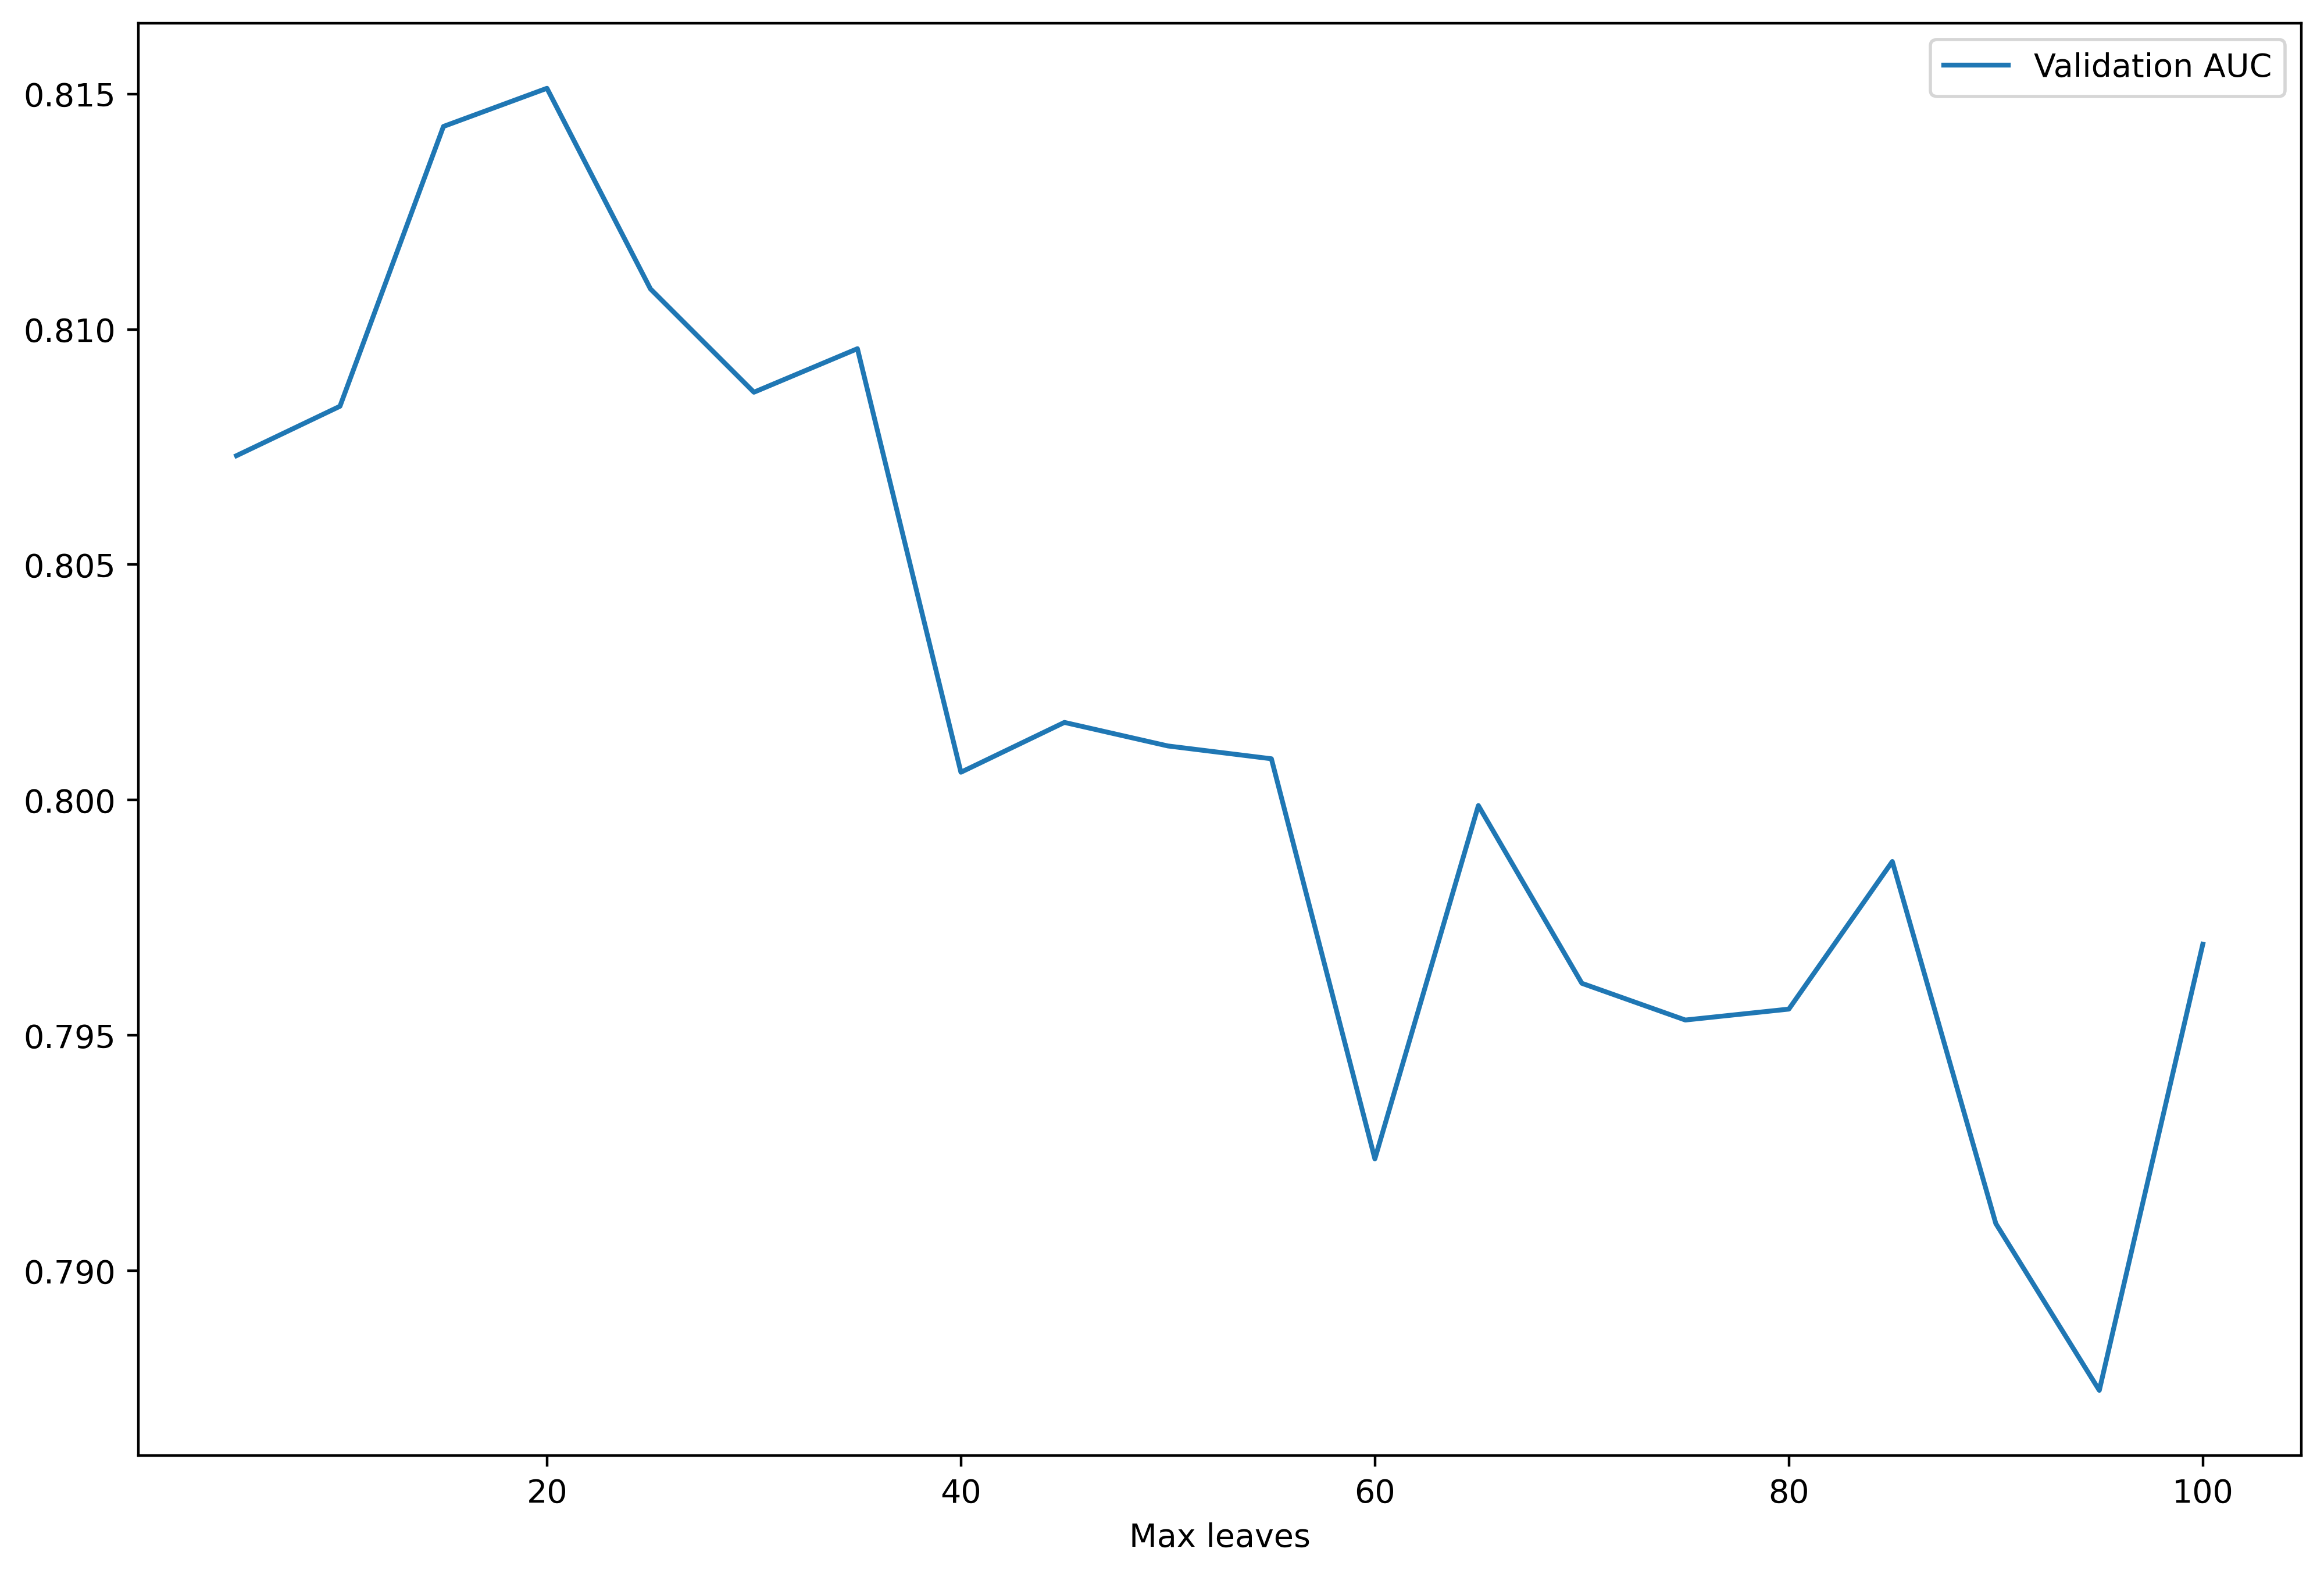

In [ ]:
mpl.rcParams['figure.dpi'] = 400
max_leaves_df.set_index('Max leaves').plot(figsize=(12,8))

In [ ]:
max_leaves_bool = max_leaves_df['Validation AUC'] == max_leaves_df['Validation AUC'].max()
max_leaves_df[max_leaves_bool]

,Max leaves,Validation AUC
3,20,0.81512


#### Explaining Model Predictions with Shap Values

In [ ]:
%%time
xgb_model_3.set_params(**{'max_leaves':20}) # refit model to optimal number of max_leaves from prev section
xgb_model_3.fit(X_train, y_train,
                eval_set=eval_set,
                verbose=False)

CPU times: user 1.18 s, sys: 406 ms, total: 1.58 s
Wall time: 279 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=0,
              max_leaves=20, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [ ]:
X_val.shape

(1000, 40)

In [ ]:
feature_names = [f'Feature {number}' for number in range(X_val.shape[1])]
X_val_df = pd.DataFrame(data=X_val, columns=feature_names)
X_val_df.head()

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39
0,1.852885,-2.170293,1.057288,0.441873,-0.803131,-0.025139,-0.037143,0.037565,1.163995,0.678410,...,-0.592176,0.529113,0.923351,0.511203,-0.390155,-0.142262,0.760561,-0.421488,1.770300,-0.292780
1,-0.818316,-1.126948,0.647810,0.092433,-1.030356,0.754323,-0.351566,-0.523476,1.144878,0.219172,...,0.545090,1.125089,0.848158,-0.870549,-1.094581,-1.480010,-2.444469,0.905715,-1.008522,1.537315
2,0.020271,-0.758004,-1.136195,0.473366,1.291465,0.890423,-2.217706,-2.030749,1.768624,-2.106202,...,-0.741205,-0.833958,-0.265291,-1.021137,0.247897,-0.058583,0.445473,0.349382,0.208958,0.252826
3,-0.271543,-0.366639,-1.139614,-0.753586,1.427853,1.249856,0.060528,-0.374193,0.047770,0.640638,...,-0.539878,0.569599,0.508334,-0.513756,0.769438,1.100097,0.682759,0.888623,-0.464301,-1.125279
4,-0.549078,0.494648,-1.266778,-0.292728,1.459779,0.497898,-0.618724,-1.225373,0.171507,0.833027,...,-0.366978,-0.308615,0.838910,0.208853,2.517458,0.471553,0.982017,0.030594,0.449982,-0.670582


In [ ]:
# create explainer interface (chose tree explainer)
explainer = shap.explainers.Tree(xgb_model_3, data=X_val_df)   # model, background data = validation data 

In [ ]:
# use explainer to obtain SHAP values by passing dataset we want explanations for (validation data)
shap_values = explainer(X_val_df)

In [ ]:
# .values attribute of object returned by explainer
shap_values.values.shape

(1000, 40)

In [ ]:
# .base_values attribute  (expected values / naive predictions before feature contributions)
shap_values.base_values.shape

(1000,)

In [ ]:
# .data attribute, which contains feature values, of object returned by explainer
shap_values.data.shape

(1000, 40)

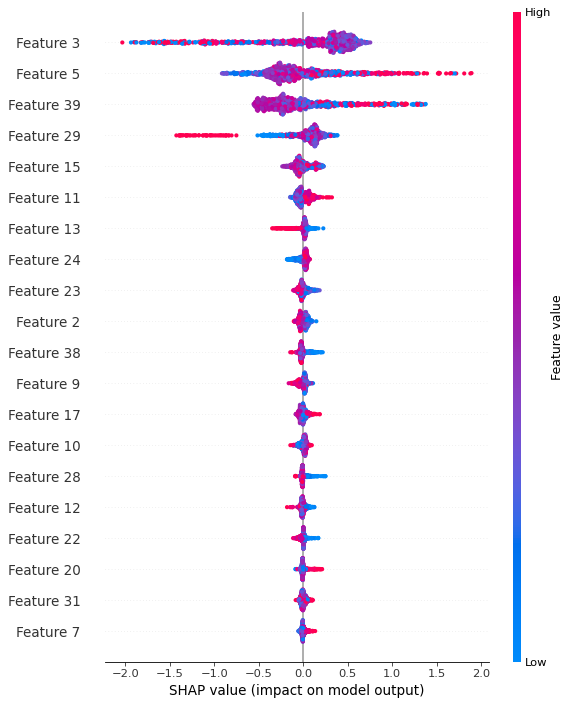

In [ ]:
# call summary_plots() method on shap package
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values.values, X_val_df) #

SHAP values for XGBoost binary classification model with the binary:logistic objective function, are calculated and plotted using the log-odds representation of probability. As such the SHAP values above cannot be directly interpreted as predicted probabilities. However, they can be added, subtracted or in other words, we can perform linear transformations on them. 

The width of the band of dots for each feature, indicates how many dots are at that location of the x-axis ie shap values. If there are many samples, the band of dots will be wider. The vertical arrangement of features in the diagram is based on feature importance. The most important features, ie those with the largest average effect (mean absolute SHAP value) on model predictions, are placed att the top of the list.

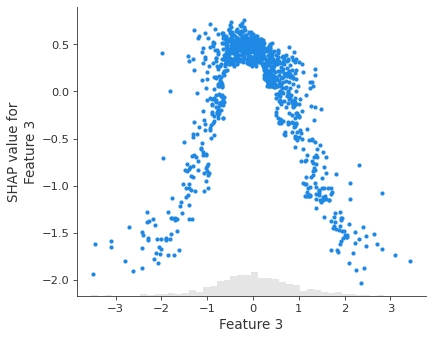

In [ ]:
# call plots.scatter() method on shap package
shap.plots.scatter(shap_values[:,'Feature 3']) 

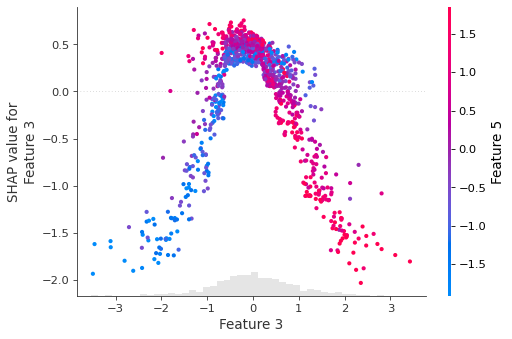

In [ ]:
# color scatter plots by another feature to identify interactions
shap.plots.scatter(shap_values[:,'Feature 3'],
                   color=shap_values[:, 'Feature 5']) 

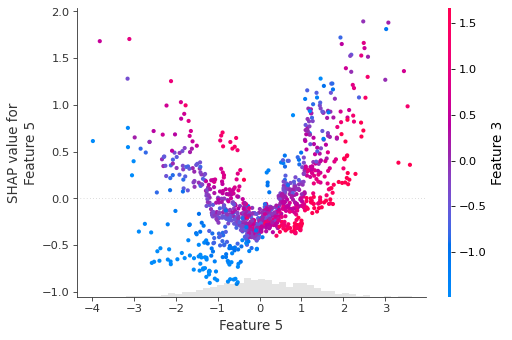

In [ ]:
# Now looking at interactions between Features 3 and 5 from Feature 5 point of view
shap.plots.scatter(shap_values[:, 'Feature 5'], color=shap_values[:, 'Feature 3'])

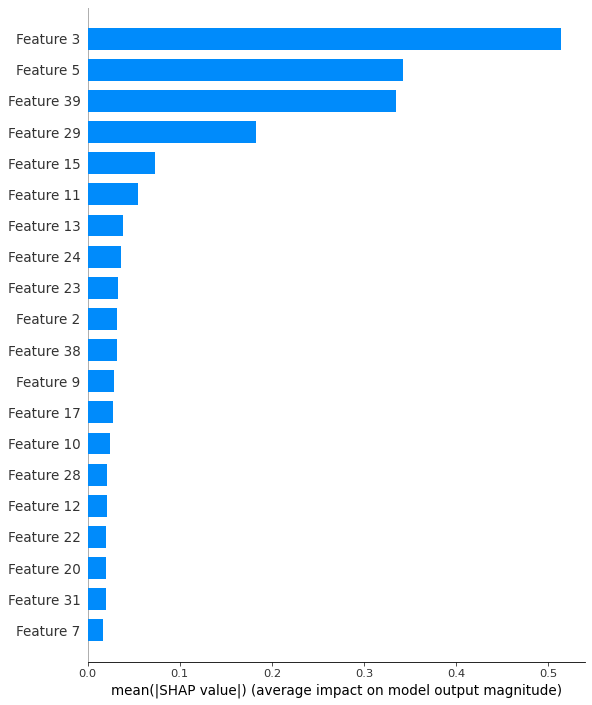

In [ ]:
# Create a feature importance bar plot (supplying plot_type='bar' to summary_plot() method of shap package)
mpl.rcParams['figure.dpi'] = 75 
shap.summary_plot(shap_values.values, X_val, plot_type='bar')

In [ ]:
# the expected value is in units of log-odds as opposed to probability
explainer.expected_value

-0.05163410541892517

In [ ]:
# shap values are the offset from the expected value so for each sample add all shap values to expected value
shap_sum = shap_values.values.sum(axis=1) + explainer.expected_value 
shap_sum.shape

(1000,)

In [ ]:
# sum of expected value and shap values is in log-odds space, apply logistic function to get probabilities
shap_sum_prob = 1 / (1 + np.exp(-1*shap_sum))

In [ ]:
# Compare predicted probabilities from SHAP values with direct model output 
y_pred_proba = xgb_model_3.predict_proba(X_val)[:,1]
y_pred_proba.shape

(1000,)

In [ ]:
df_check = pd.DataFrame({'SHAP sum': shap_sum_prob,
                         'Predicted Probability': y_pred_proba})
df_check.sample(5, random_state=1)

,SHAP sum,Predicted Probability
507,0.497260,0.497260
818,0.466160,0.466160
452,0.881343,0.881343
368,0.145347,0.145347
242,0.481065,0.481065


In [ ]:
# check that elements of both columns are equal within rounding error
np.allclose(df_check['SHAP sum'], df_check['Predicted Probability'])

True

#### Modeling Case Study Data with XGBoost and Explaining Model with SHAP

XGBoost is able to handle missing values, so when we don't have to worry about cleaning those up.  At every opportunity to split a node, XGBoost considers only the non-missing feature values. If a feature with missing values is chosen to make a split, the samples with missing values for that feature are sent down the optimal path to one of the child nodes, in terms of minimizing the loss function. Below we import a version of the case study data that still has missing values.

In [28]:
with open('Data/Activity_6_01_data.pkl', 'rb') as f:
    features_response, X_train_all, y_train_all, X_test_all, y_test_all = pickle.load(f)

In [29]:
# Define a validation set to train XGBoost with early stopping
from sklearn.model_selection import train_test_split 
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train_all, y_train_all, 
                                                          test_size=0.2, random_state=24)

In [ ]:
# Using lossguide grow policy and hist tree_method
xgb_model_4 = xgb.XGBClassifier(n_estimators=1000,
                                max_depth=0,        # when using lossguide guide policy, set max_depth to 0
                                learning_rate=0.1,
                                verbosity=1,
                                objective='binary:logistic',
                                n_jobs=-1,
                                tree_method='hist',
                                grow_policy='lossguide',
                                eval_metric='auc',
                                early_stopping_rounds=30)

In [ ]:
# since we are using lossguide grow policy we will tune the max leaves
max_leaves_values = list(range(5,205,5))
print(max_leaves_values[:5])
print(max_leaves_values[-5:])

[5, 10, 15, 20, 25]
[180, 185, 190, 195, 200]


In [30]:
# the last tuple is the validation set that will trigger early stopping
eval_set_2 = [(X_train_2, y_train_2), [X_val_2, y_val_2]]

In [ ]:
%%time
val_aucs = []
for max_leaves in max_leaves_values:
    # Set parameter and fit model
    xgb_model_4.set_params(**{'max_leaves': max_leaves})        # set the hyperparameter value
    xgb_model_4.fit(X_train_2, y_train_2, eval_set=eval_set_2,
                    verbose=False)
    # Get validation score 
    val_set_pred_proba = xgb_model_4.predict_proba(X_val_2)[:,1]
    val_aucs.append(roc_auc_score(y_val_2, val_set_pred_proba))

CPU times: user 2min 25s, sys: 57.6 s, total: 3min 22s
Wall time: 30.6 s


In [ ]:
max_leaves_df_2 = pd.DataFrame({'Max leaves': max_leaves_values,
                                'Validation AUC': val_aucs})

<Axes: xlabel='Max leaves'>

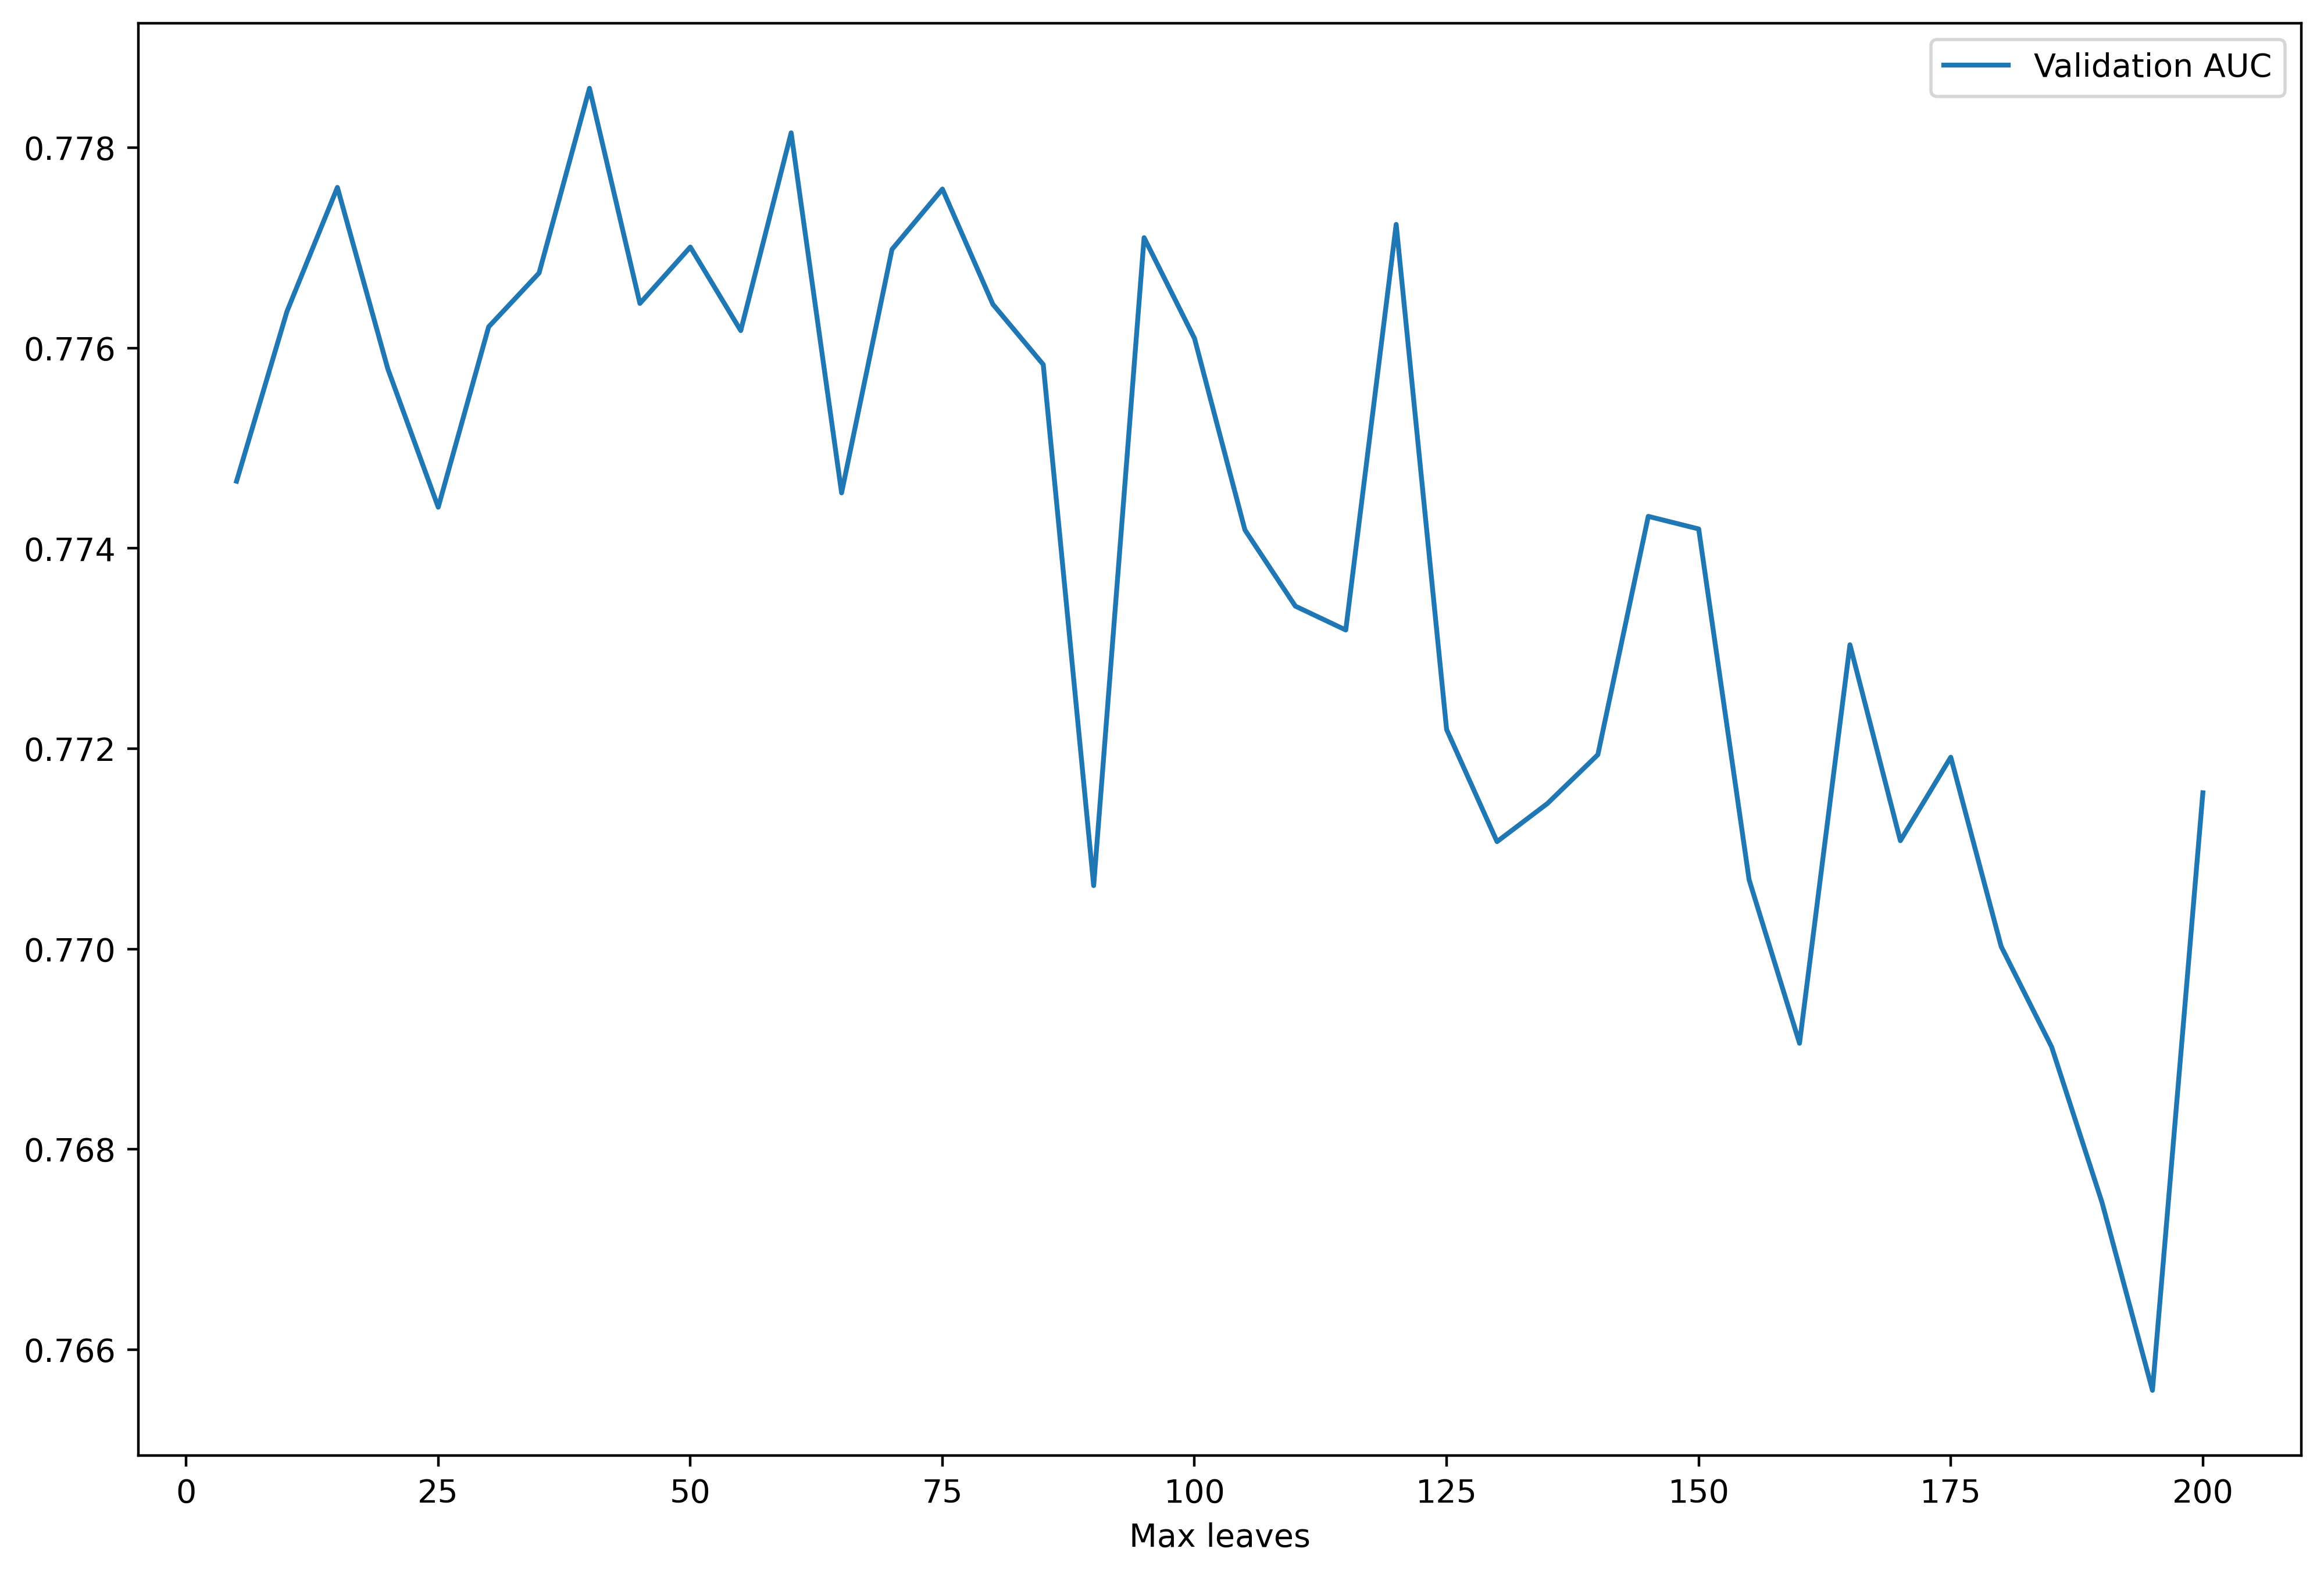

In [ ]:
mpl.rcParams['figure.dpi'] = 400 
max_leaves_df_2.set_index('Max leaves').plot(figsize=(12,8))

In [ ]:
# maximum evaluation metric
max_auc_2 = max_leaves_df_2['Validation AUC'].max()
max_auc_2

0.7785918508068121

In [ ]:
max_ix_2  = max_leaves_df_2['Validation AUC'] == max_auc_2  # boolean mask
max_leaves_df_2[max_ix_2]

,Max leaves,Validation AUC
7,40,0.778592


In [ ]:
# Retrain with optimal hyperparameter
xgb_model_4.set_params(**{'max_leaves':40})  # update max_leaves hyperparameter
xgb_model_4.fit(X_train_2, y_train_2,
                eval_set=eval_set_2,
                verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=0,
              max_leaves=40, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [ ]:
X_val_2_df = pd.DataFrame(data=X_val_2, columns=features_response[:-1])
X_val_2_df.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,50000.0,2.0,1.0,39.0,-1.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0
1,400000.0,1.0,2.0,29.0,0.0,7191.0,8856.0,6181.0,7859.0,4899.0,1466.0,2000.0,1500.0,2000.0,1000.0,500.0,1000.0
2,200000.0,2.0,2.0,26.0,0.0,22737.0,12169.0,14328.0,16222.0,9915.0,11226.0,3000.0,6000.0,3000.0,2003.0,3101.0,530.0
3,280000.0,1.0,2.0,38.0,-1.0,17878.0,14011.0,30079.0,13139.0,13989.0,15559.0,2000.0,30000.0,14000.0,1000.0,16000.0,0.0
4,80000.0,3.0,1.0,65.0,0.0,80260.0,82116.0,80299.0,81416.0,81617.0,81607.0,3750.0,3520.0,3069.0,3271.0,3262.0,3237.0


#### SHAP Summary

In [ ]:
%time
explainer_2 = shap.explainers.Tree(xgb_model_4, data=X_val_2_df) # validation data (hyperparameters) background

CPU times: user 0 ns, sys: 1e+03 ns, total: 1e+03 ns
Wall time: 3.1 µs


In [ ]:
%time 
shap_values_2 = explainer_2(X_val_2_df) # used the line magic command for time

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


In [ ]:
shap_values_2.values.shape

(4750, 17)

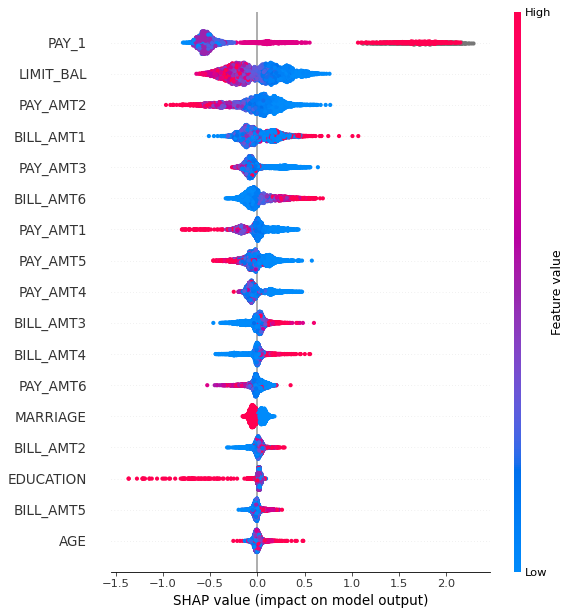

CPU times: user 1.24 s, sys: 10.1 ms, total: 1.25 s
Wall time: 430 ms


In [ ]:
%%time 
mpl.rcParams['figure.dpi'] = 75     # used the cell magic command for time
shap.summary_plot(shap_values_2.values, X_val_2_df)

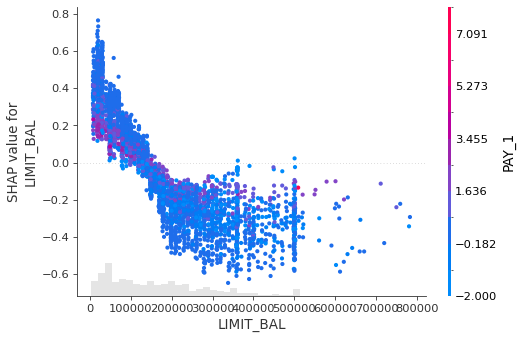

In [ ]:
# look for strongest interaction effect
shap.plots.scatter(shap_values_2[:, 'LIMIT_BAL'], color=shap_values_2)

In [ ]:
# Save features and response name list, training and testing sets, and trained model to analyze later
with open('intermediate_data/xgb_model_w_data.pkl', 'wb') as f:
    pickle.dump([features_response,
                 X_train_all, y_train_all,
                 X_test_all, y_test_all,
                 xgb_model_4], f)

#### Missing Values

In [ ]:
# Load raw case study data
df_orig = pd.read_excel('Data/default_of_credit_card_clients__courseware_version_1_21_19.xls')

In [ ]:
# Repeat previous data cleaning steps: remove samples where all features and response are zero (repeated IDs)
df_zero_mask = df_orig == 0     # boolean dataframe
feature_zero_mask = df_zero_mask.iloc[:, 1:].all(axis=1)  # whether all elements along axis are True (except ID)
sum(feature_zero_mask)

315

In [ ]:
# filter out samples that are not all-zero rows
df_clean = df_orig.loc[~feature_zero_mask, :] # invert boolean series to index rows
print(df_clean.shape)
print(df_clean['ID'].nunique())

(29685, 25)
29685


In [ ]:
# Repeat previous data cleaning steps: adjust undocumented feature values
df_clean['EDUCATION'].replace(to_replace=[0,5,6], value=4, inplace=True)
df_clean['EDUCATION'].value_counts() # why get a set, when you can get a hashmap


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


EDUCATION
2    13884
1    10474
3     4867
4      460
Name: count, dtype: int64

In [ ]:
df_clean['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)
df_clean['MARRIAGE'].value_counts()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MARRIAGE
2    15810
1    13503
3      372
Name: count, dtype: int64

Now that all cleaning steps are complete, instead of throwing away samples with missing data, we will fill them with np.nan which XGBoost can work with. Now we have a dataframe that only contains the samples that were previously filtered out.

In [ ]:
# boolean Series mask identifying the samples that have invalid values for PAY_1
missing_pay_1_mask = df_clean['PAY_1'] == 'Not available'   # boolean mask
sum(missing_pay_1_mask)                                     # sum boolean mask 

3021

In [ ]:
# filter out the samples that have invalid values for PAY_1 
df_missing_pay_1 = df_clean.loc[missing_pay_1_mask, :].copy() # we make a copy instead of a view on 
df_missing_pay_1.shape

(3021, 25)

In [ ]:
# filtered samples still have the old index
df_missing_pay_1['PAY_1'].head(3)

17    Not available
28    Not available
29    Not available
Name: PAY_1, dtype: object

We import the cleaned version that had samples with 'Not available' in PAY_1 column removed. We split this into train and test datasets. We make a similar train/test split with the dataframe that has only missing values, after changing 'Not available' to np.nan. We are able to make a similar split by using the same random state. Then we concatenate the imputed data with the non-missing data. Note that the missing data was filtered out to yield the non-missing data, so when we concatenate the non-missing data with the previously missing data, now imputed data we will still only have one record per sample.

In [ ]:
# Load cleaned data that had value removed
df = pd.read_csv('intermediate_data/Chapter_1_cleaned_data.csv')

In [ ]:
features_response = df.columns.tolist()
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                   'PAY_6', 'EDUCATION_CAT', 'graduate school',    # remove due to ethical/data integrity issues
                   'high school', 'none', 'others', 'university'] 
features_response  = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(df[features_response[:-1]].values,
                                                    df['default payment next month'].values,
                                                    test_size=0.2, random_state=24)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21331, 17)
(5333, 17)
(21331,)
(5333,)


In [ ]:
df_missing_pay_1.shape

(3021, 25)

In [ ]:
# Copy the data frame with missing PAY_1 and assign imputed values 
df_fill_pay_1_filled = df_missing_pay_1.copy()  
df_fill_pay_1_filled['PAY_1'] = np.nan       # these are the samples with 'Not available'; replace with np.nan

# Split imputed data in to training and testing, using the same
# 80/20 split and random_state we have used for the data with non-missing PAY_1
X_fill_pay_1_train, X_fill_pay_1_test,\
      y_fill_pay_1_train, y_fill_pay_1_test = \
        train_test_split(df_fill_pay_1_filled[features_response[:-1]], 
                                              df_fill_pay_1_filled['default payment next month'],
                                              test_size=0.2, random_state=24) # 

# Concatenate the imputed data with the array of non-missing data
X_train_all = np.concatenate([X_train, X_fill_pay_1_train], axis=0)
y_train_all = np.concatenate([y_train, y_fill_pay_1_train], axis=0) # non-missing, imputed

In [ ]:
with open('intermediate_data/Activity_6_01_data.pkl', 'wb') as f:
    pickle.dump([features_response,
                 X_train_all, y_train_all,
                 X_test_all, y_test_all], f)